In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=a847c

## 1. Import Dataset

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3348.20it/s]


## 2. Fix the error in the json file

In [4]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


## 3. SetUp

In [1]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Device: cuda | torch 2.7.1+cu128


## 4. Path Declaration and COCO --> YOLO Conversion

In [6]:

COCO_ROOT     = Path("/kaggle/working/Final-1")  # folder containing train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"
WORK          = Path("/kaggle/working/SSL-DINO")  # output directory (can rename)
SSL_W         = WORK / "ssl_yolov11_backbone.pt"
WORK.mkdir(parents=True, exist_ok=True)

# Create output directory structure
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        (WORK / split / sub).mkdir(parents=True, exist_ok=True)

# Function to convert COCO bbox to YOLO format
def coco2yolo(box, w, h):
    x, y, w_box, h_box = box
    return ((x + w_box/2) / w, (y + h_box/2) / h, w_box / w, h_box / h)

# Convert one split from COCO to YOLO format
def convert(split, img_dir, ann_file, out_dir):
    with open(ann_file, "r") as f:
        coco = json.load(f)

    id2img = {img["id"]: img for img in coco["images"]}
    imgs_o = out_dir / split / "images"
    labs_o = out_dir / split / "labels"

    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        yolo_box = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = ann["category_id"] - 1  # Class index starts from 0 in YOLO
        label_path = labs_o / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")

    for img in coco["images"]:
        shutil.copy(img_dir / img["file_name"], imgs_o / img["file_name"])

# ----------------------------------------------------------------------------
# 1. Perform Conversion
# ----------------------------------------------------------------------------
convert("train", TRAIN_IMG_DIR, TRAIN_ANN, WORK)
convert("valid", VAL_IMG_DIR,   VAL_ANN,   WORK)
convert("test",  TRAIN_IMG_DIR, TRAIN_ANN, WORK)  # Optional test reuse


## 5. Save the YAML file

In [7]:
import yaml

cats  = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
data_cfg = {
    "path":  str(WORK),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names
}
DATA = WORK / "data_Sunflower.yaml"
(DATA).write_text(yaml.dump(data_cfg))

112

## 6. Multi-crop Augmentation (DINOv2-style: 2 global + 8 local)

In [8]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

## 7. Build YOLO V11s model type backbone dino-v2 style

In [2]:
detector = YOLO("yolo11s.pt")   # requires Ultralytics with YOLOv10 assets
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo11s.pt").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


## 8. DINO-v2 style projection head and loss function

In [10]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


## 9. DINOv2-style self training loop with hyperparameter and optimizer

In [11]:

EPOCHS     = 50       # increase to 50–100 for stronger transfer
BATCH      = 32
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\n DINOv2-style pretraining on YOLOv11s backbone …")
    ds = MultiCropDINO([WORK/"train/images", WORK/"valid/images", WORK/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))
    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv11s backbone →", SSL_W)
    print("✓ DINOv2-style pretraining complete.\n")


 DINOv2-style pretraining on YOLOv11s backbone …


SSL Ep 1/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 01: loss=5.6587


SSL Ep 2/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 02: loss=4.5606


SSL Ep 3/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 03: loss=4.8775


SSL Ep 4/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 04: loss=5.4301


SSL Ep 5/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 05: loss=5.6195


SSL Ep 6/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 06: loss=5.5251


SSL Ep 7/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 07: loss=5.3844


SSL Ep 8/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 08: loss=5.2780


SSL Ep 9/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 09: loss=5.0327


SSL Ep 10/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 10: loss=5.0069


SSL Ep 11/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 11: loss=4.9203


SSL Ep 12/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 12: loss=4.8578


SSL Ep 13/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 13: loss=4.7806


SSL Ep 14/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 14: loss=4.7347


SSL Ep 15/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 15: loss=4.7231


SSL Ep 16/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 16: loss=4.7181


SSL Ep 17/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 17: loss=4.7275


SSL Ep 18/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 18: loss=4.6965


SSL Ep 19/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 19: loss=4.6792


SSL Ep 20/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 20: loss=4.6552


SSL Ep 21/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 21: loss=4.6396


SSL Ep 22/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 22: loss=4.6345


SSL Ep 23/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 23: loss=4.6234


SSL Ep 24/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 24: loss=4.6139


SSL Ep 25/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 25: loss=4.6014


SSL Ep 26/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 26: loss=4.5860


SSL Ep 27/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 27: loss=4.5853


SSL Ep 28/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 28: loss=4.5682


SSL Ep 29/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 29: loss=4.5574


SSL Ep 30/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 30: loss=4.5608


SSL Ep 31/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 31: loss=4.5287


SSL Ep 32/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 32: loss=4.5391


SSL Ep 33/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 33: loss=4.5288


SSL Ep 34/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 34: loss=4.5144


SSL Ep 35/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 35: loss=4.5110


SSL Ep 36/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 36: loss=4.4992


SSL Ep 37/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 37: loss=4.4976


SSL Ep 38/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 38: loss=4.4942


SSL Ep 39/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 39: loss=4.4949


SSL Ep 40/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 40: loss=4.4905


SSL Ep 41/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 41: loss=4.4908


SSL Ep 42/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 42: loss=4.4852


SSL Ep 43/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 43: loss=4.4853


SSL Ep 44/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 44: loss=4.4868


SSL Ep 45/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 45: loss=4.4716


SSL Ep 46/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 46: loss=4.4725


SSL Ep 47/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 47: loss=4.4702


SSL Ep 48/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 48: loss=4.4686


SSL Ep 49/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 49: loss=4.4682


SSL Ep 50/50:   0%|          | 0/252 [00:00<?, ?it/s]

SSL Epoch 50: loss=4.4694
✓ Saved SSL YOLOv11s backbone → /kaggle/working/SSL-DINO/ssl_yolov11_backbone.pt
✓ DINOv2-style pretraining complete.



## 10. PCA Visualization of K-Means clustering

PCA Feature matrix: (1000, 32)


d:\EWU\10th Semester\CSE475\LABS\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


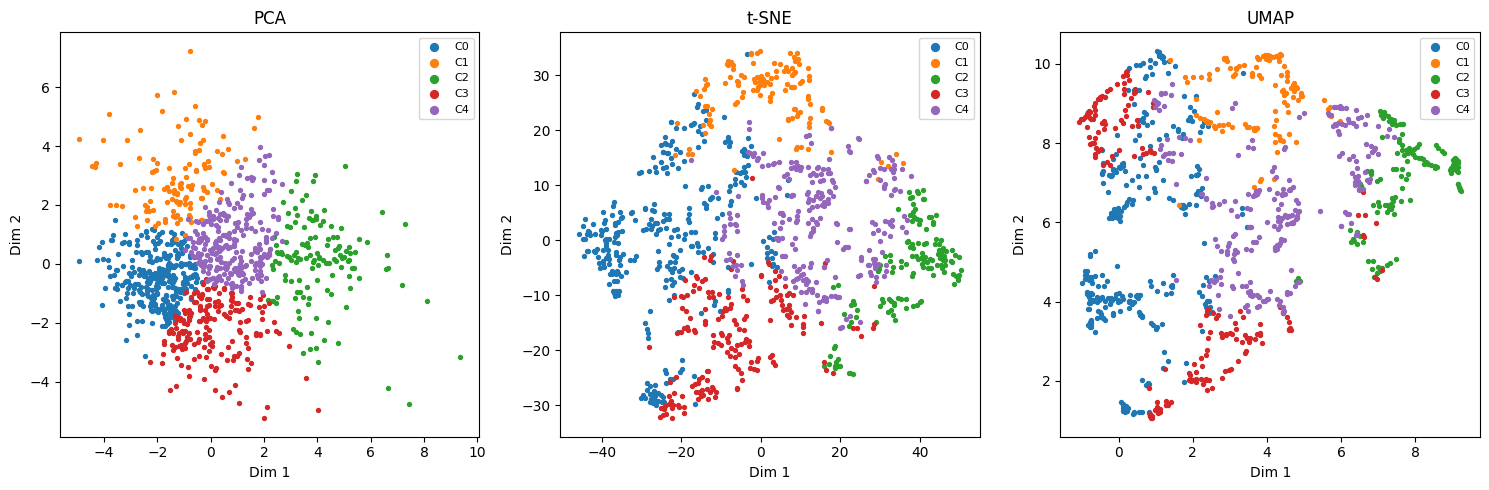

In [4]:
import umap.umap_ as umap
from sklearn.manifold import TSNE

WORK          = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO")

SSL_W = WORK / "ssl_yolov11_backbone.pt"
DATA = WORK / "data_Sunflower.yaml"
det_pca = YOLO("yolo11s.pt")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [WORK/"train/images", WORK/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy_pca = pca.fit_transform(feats)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
xy_tsne = tsne.fit_transform(feats)

# UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
xy_umap = umap_model.fit_transform(feats)

# ================================
# Clustering (Same labels for all plots)
# ================================
k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

# ================================
# Plotting
# ================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
methods = [("PCA", xy_pca), ("t-SNE", xy_tsne), ("UMAP", xy_umap)]

for ax, (title, xy) in zip(axes, methods):
    for i in range(k):
        m = (lab == i)
        ax.scatter(xy[m, 0], xy[m, 1], s=8, label=f"C{i}")
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(markerscale=2, fontsize=8)

plt.tight_layout()
plt.show()


## 11. Detector Fine-Tuning with SSL Backbone

In [13]:

det = YOLO("yolo11s.pt")  # fresh model
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(data=str(DATA),
          epochs=50,
          imgsz=640,
          batch=8,
          save=True,
          save_period=1,
          project=str(WORK),
          name="ssl_yolov11s_dinov2",
          device=0 if device=="cuda" else "cpu")

Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/SSL-DINO/data_Sunflower.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov11s_dinov2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2423.8±607.8 MB/s, size: 98.7 KB)


train: Scanning /kaggle/working/SSL-DINO/train/labels... 3957 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3957/3957 [00:03<00:00, 1153.85it/s]


train: New cache created: /kaggle/working/SSL-DINO/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 549.7±502.9 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/SSL-DINO/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 1078.30it/s]

val: New cache created: /kaggle/working/SSL-DINO/valid/labels.cache


Plotting labels to /kaggle/working/SSL-DINO/ssl_yolov11s_dinov2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/SSL-DINO/ssl_yolov11s_dinov2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.69G      1.625     0.9755      1.118        337        640: 100%|██████████| 495/495 [01:31<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

                   all        165      13823      0.792      0.777      0.847      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.32G      1.487      0.809      1.036        843        640: 100%|██████████| 495/495 [01:28<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

                   all        165      13823      0.835      0.808      0.886      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.35G      1.458     0.7817      1.021        774        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.20it/s]

                   all        165      13823      0.841      0.804      0.885      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.39G      1.436     0.7685      1.012        486        640: 100%|██████████| 495/495 [01:29<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        165      13823      0.844      0.808      0.892      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.44G      1.411     0.7444      1.005        492        640: 100%|██████████| 495/495 [01:29<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        165      13823      0.849        0.8       0.89      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.46G      1.395     0.7383     0.9968        617        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        165      13823      0.842      0.814      0.896      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.51G      1.378     0.7264      0.993        859        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.21it/s]

                   all        165      13823      0.845      0.816      0.894      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.55G      1.368     0.7129     0.9855        658        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        165      13823      0.846      0.823      0.899      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.59G      1.353     0.7063     0.9802        648        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        165      13823       0.85      0.818      0.897      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.63G      1.344     0.6984     0.9758        332        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823      0.863      0.816      0.904      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.67G       1.34     0.6909     0.9744        282        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        165      13823      0.855      0.821      0.902      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.71G      1.325     0.6842     0.9701        473        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.29it/s]

                   all        165      13823      0.859      0.825      0.908      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.75G      1.319     0.6778     0.9696        578        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        165      13823       0.85      0.812      0.899       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.78G      1.323     0.6803     0.9696        414        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        165      13823      0.852      0.834      0.908      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.83G      1.318     0.6754     0.9695        629        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        165      13823      0.849      0.829      0.905      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.87G      1.305     0.6687     0.9666        509        640: 100%|██████████| 495/495 [01:29<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823       0.85      0.827      0.902      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.91G      1.305     0.6682     0.9656        474        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823       0.84      0.827      0.899      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.54G      1.298      0.662     0.9626        825        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        165      13823       0.85      0.832      0.904      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.99G      1.292     0.6569     0.9608        656        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        165      13823      0.856      0.833      0.909      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.52G      1.288     0.6547       0.96        594        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        165      13823      0.855       0.83      0.907      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.52G      1.278     0.6477     0.9584        570        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        165      13823      0.855      0.832      0.909      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.52G      1.277     0.6458     0.9557        535        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        165      13823      0.856      0.828      0.908      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.09G      1.276     0.6452     0.9568        301        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823      0.859      0.832      0.911      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.13G      1.269     0.6424     0.9556        467        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        165      13823      0.856      0.833       0.91      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.17G      1.261     0.6351     0.9514        633        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823      0.862      0.828       0.91      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.21G      1.264     0.6376     0.9512        264        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.862      0.833       0.91      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.25G      1.258     0.6301     0.9528        462        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]

                   all        165      13823      0.869      0.835      0.915       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.29G      1.254     0.6292     0.9501        579        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        165      13823      0.855      0.833      0.909      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.33G      1.247      0.624     0.9474        670        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        165      13823      0.856      0.841      0.914      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.35G      1.247     0.6253      0.948        230        640: 100%|██████████| 495/495 [01:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.22it/s]

                   all        165      13823      0.858      0.838      0.914      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.41G      1.245     0.6214     0.9469        455        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.09it/s]

                   all        165      13823      0.866      0.834      0.913      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.45G      1.246      0.621     0.9465        407        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        165      13823      0.859      0.838      0.913      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.49G      1.241     0.6181     0.9444        322        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        165      13823      0.859      0.842      0.917      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.53G      1.231     0.6117     0.9412        276        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

                   all        165      13823      0.863      0.837      0.916      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.57G      1.236     0.6141     0.9432        729        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823      0.865      0.834      0.916      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.61G      1.227     0.6092     0.9407        582        640: 100%|██████████| 495/495 [01:29<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.11it/s]

                   all        165      13823      0.863      0.833      0.914      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.65G      1.222     0.6039     0.9386        490        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        165      13823      0.865      0.839      0.916      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.67G      1.218     0.6041     0.9385        586        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        165      13823      0.868      0.837      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.73G      1.218     0.6004     0.9385        421        640: 100%|██████████| 495/495 [01:29<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.29it/s]

                   all        165      13823      0.863       0.84      0.918      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.77G      1.211     0.5978     0.9372        483        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823      0.861      0.843      0.917      0.588


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.81G      1.215     0.5915     0.9457        279        640: 100%|██████████| 495/495 [01:24<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.25it/s]

                   all        165      13823      0.853      0.843      0.913      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.85G      1.203     0.5846     0.9391        263        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]

                   all        165      13823      0.859      0.842      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.89G      1.199     0.5811       0.94        389        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.13it/s]

                   all        165      13823      0.866       0.84      0.917      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.93G      1.189     0.5766     0.9374        476        640: 100%|██████████| 495/495 [01:23<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.21it/s]

                   all        165      13823      0.865      0.842      0.917      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.97G      1.185     0.5735     0.9367        509        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.28it/s]

                   all        165      13823      0.867      0.841      0.918      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.99G       1.18     0.5703     0.9355        336        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

                   all        165      13823      0.862      0.842      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.05G       1.18     0.5679     0.9349        349        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        165      13823      0.865      0.843      0.917       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.09G      1.171     0.5633      0.931        383        640: 100%|██████████| 495/495 [01:23<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        165      13823      0.868       0.84      0.918      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.12G      1.167     0.5598     0.9307        374        640: 100%|██████████| 495/495 [01:23<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.06it/s]

                   all        165      13823      0.862      0.843      0.916      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.17G      1.163      0.558     0.9294        179        640: 100%|██████████| 495/495 [01:23<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.27it/s]

                   all        165      13823      0.865       0.84      0.917      0.589



50 epochs completed in 1.267 hours.
Optimizer stripped from /kaggle/working/SSL-DINO/ssl_yolov11s_dinov2/weights/last.pt, 19.2MB
Optimizer stripped from /kaggle/working/SSL-DINO/ssl_yolov11s_dinov2/weights/best.pt, 19.2MB

Validating /kaggle/working/SSL-DINO/ssl_yolov11s_dinov2/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:00<00:02,  3.70it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.26s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.862      0.836       0.91      0.585
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 37.4ms postprocess per image
Results saved to /kaggle/working/SSL-DINO/ssl_yolov11s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e68e30b3910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## 12. Loss Curve Visualization

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


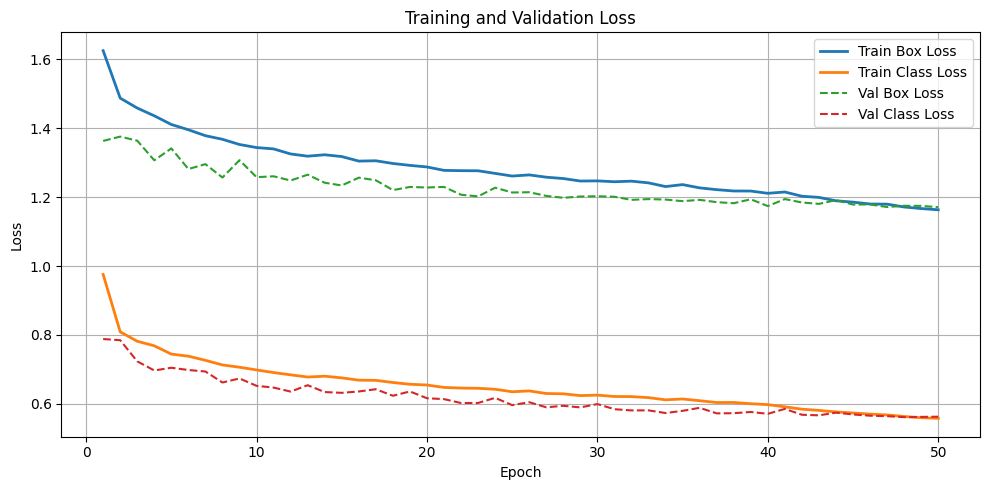

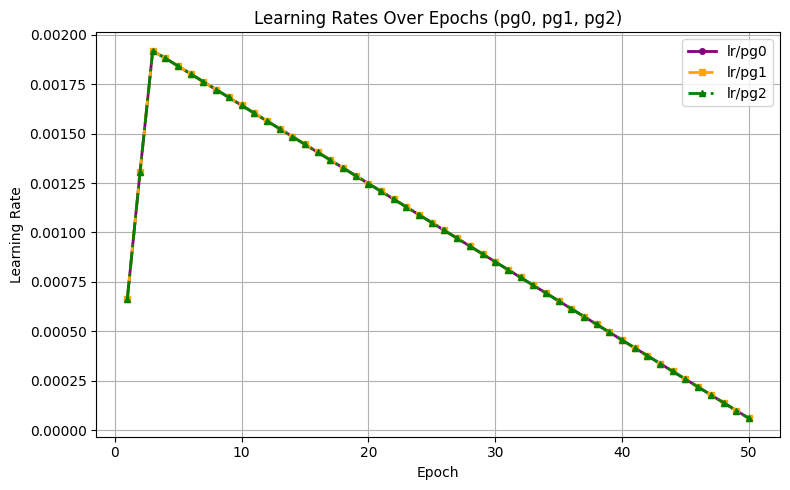

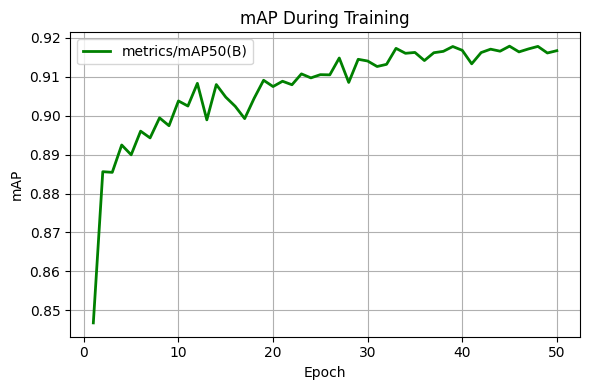

In [14]:
# ----------------------------------------------------------------------------
# 3. Visualize Training Metrics
# ----------------------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "ssl_yolov11s_dinov2" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


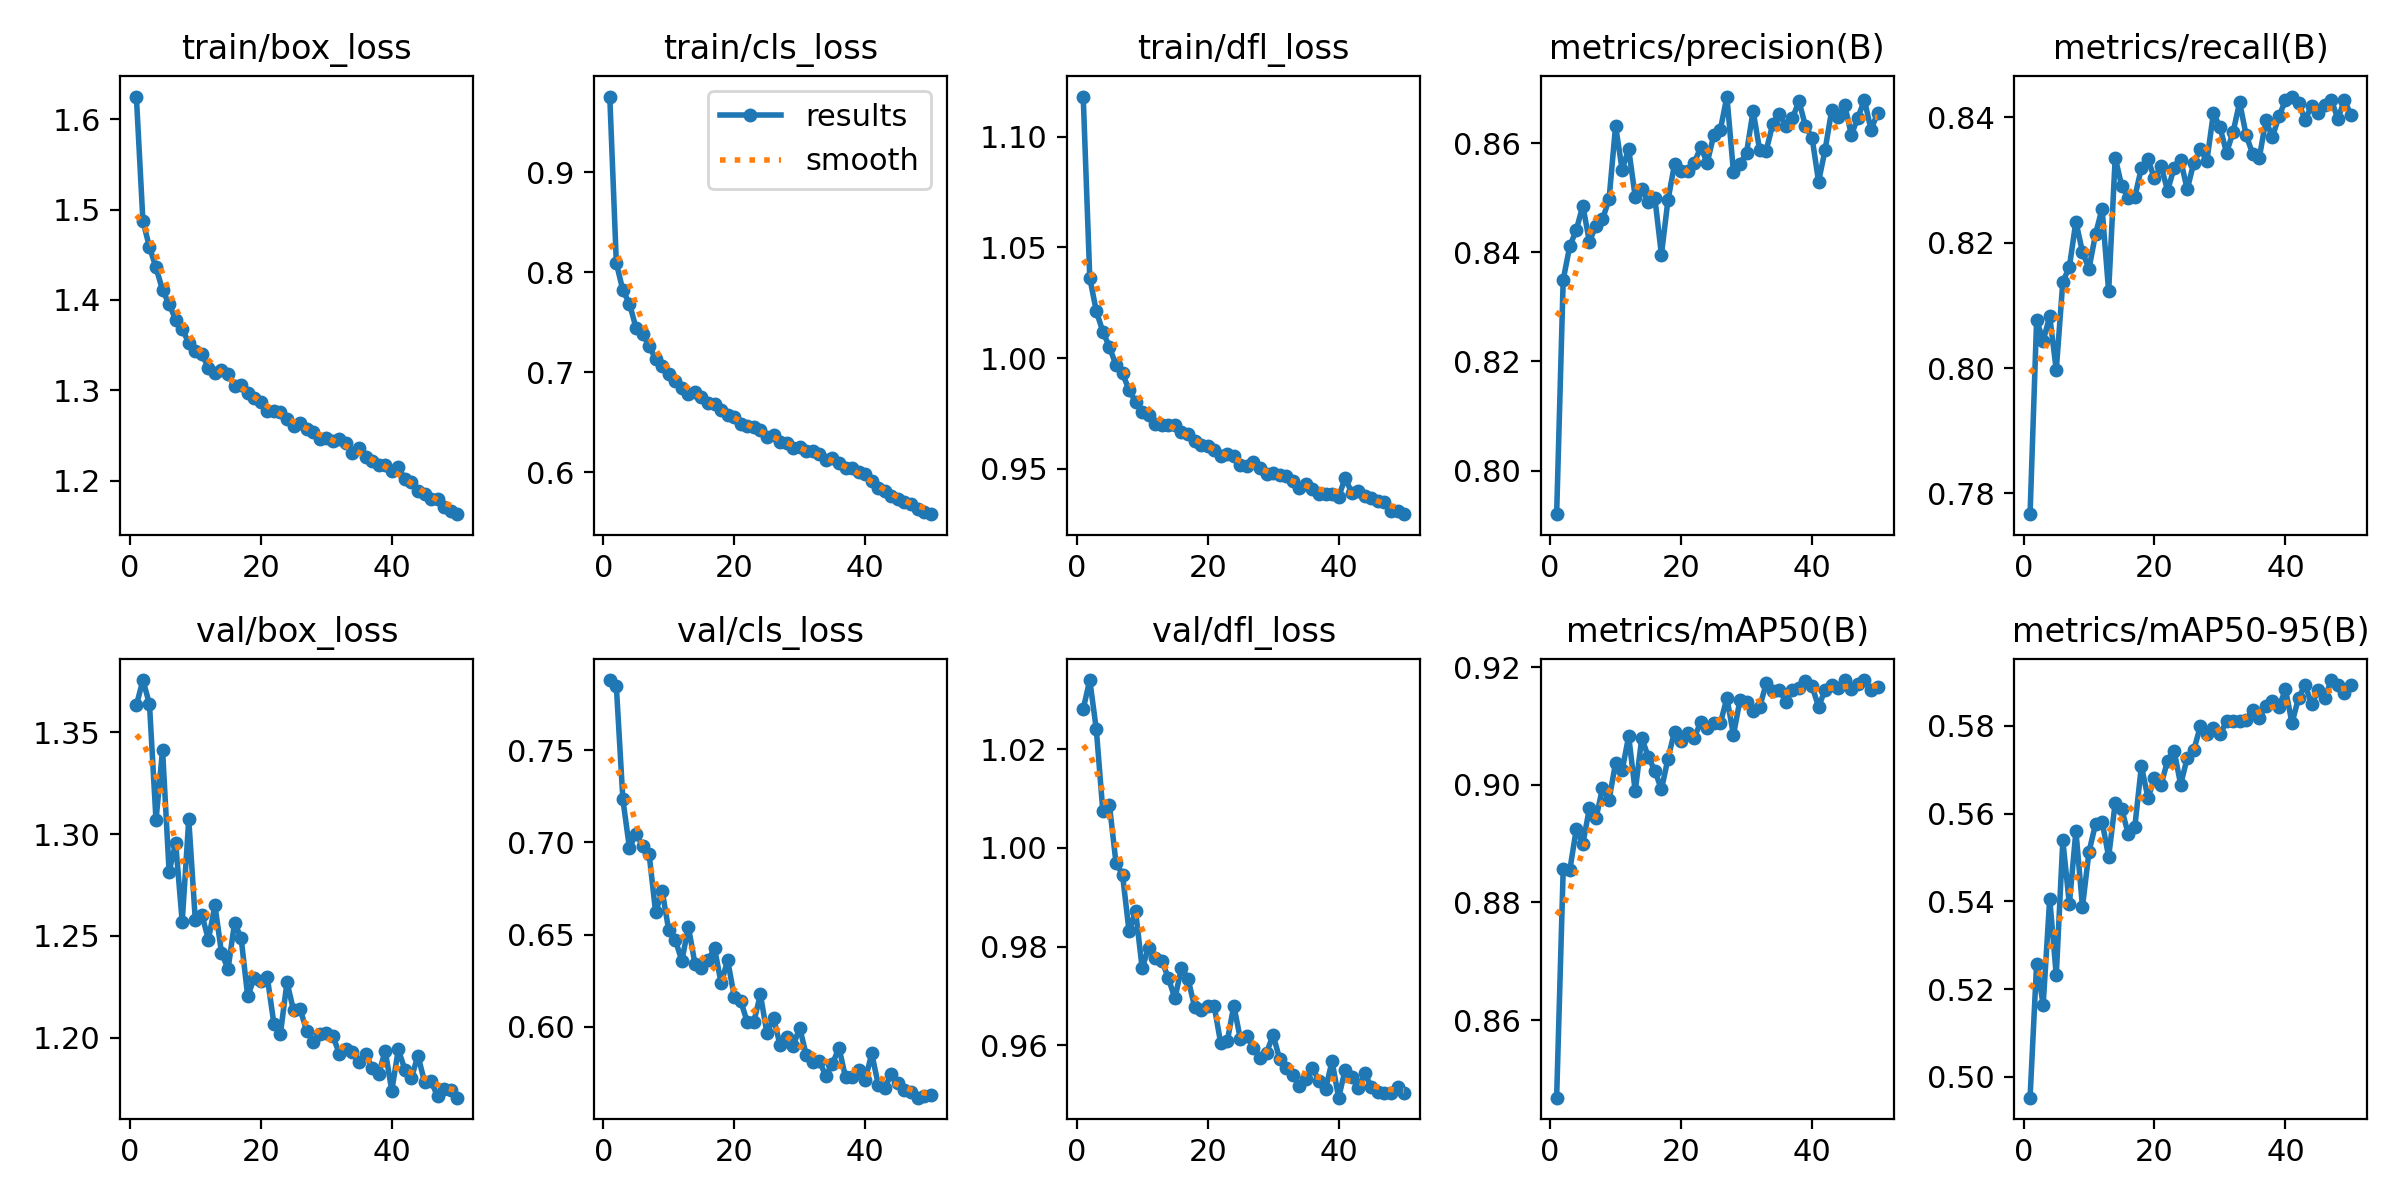

In [15]:
from PIL import Image
from IPython.display import display

results_img = WORK / "ssl_yolov11s_dinov2" / "results.png"
img = Image.open(results_img)
display(img)


## 13. Evalution and Example images of detection

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1828.4±299.2 MB/s, size: 101.9 KB)


val: Scanning /kaggle/working/SSL-DINO/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:05<00:00,  7.48it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.863      0.844      0.918      0.592
Speed: 0.8ms preprocess, 22.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.8634
 Recall    (mR) : 0.8437
 mAP@0.50      : 0.9177
 mAP@0.50-0.95 : 0.5917


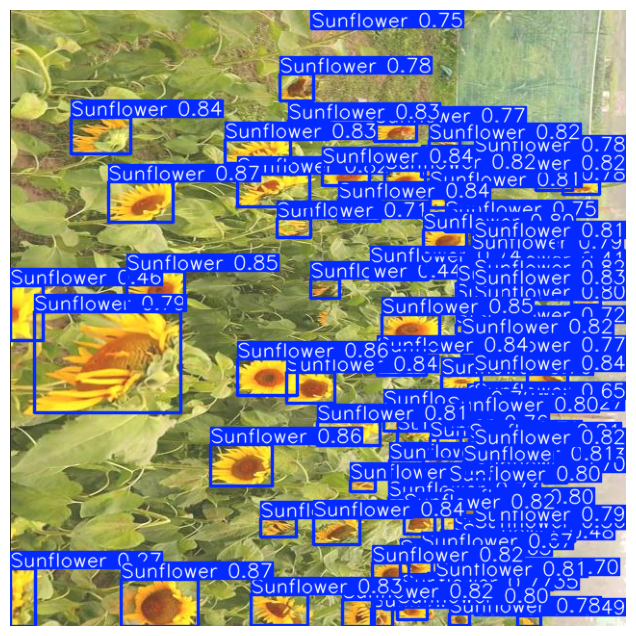

In [16]:
best_pt = WORK / "ssl_yolov11s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# visualize a random test image
test_imgs = list((WORK/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")

[1] Predicting: MVI_9998-MP4_frame14_jpg.rf.edbb43e6d36cd32033d03aac125a4b96.jpg
[2] Predicting: MVI_0006-MP4_frame10_jpg.rf.f770c2ce1e8ba2d71a2b4a850df47649.jpg
[3] Predicting: MVI_9998-MP4_frame17_jpg.rf.3ffd521112c39d85fea730359329ec71.jpg
[4] Predicting: MVI_9812-MP4_frame10_jpg.rf.5892bfc4cc3f5fedf92760634b1f1877.jpg


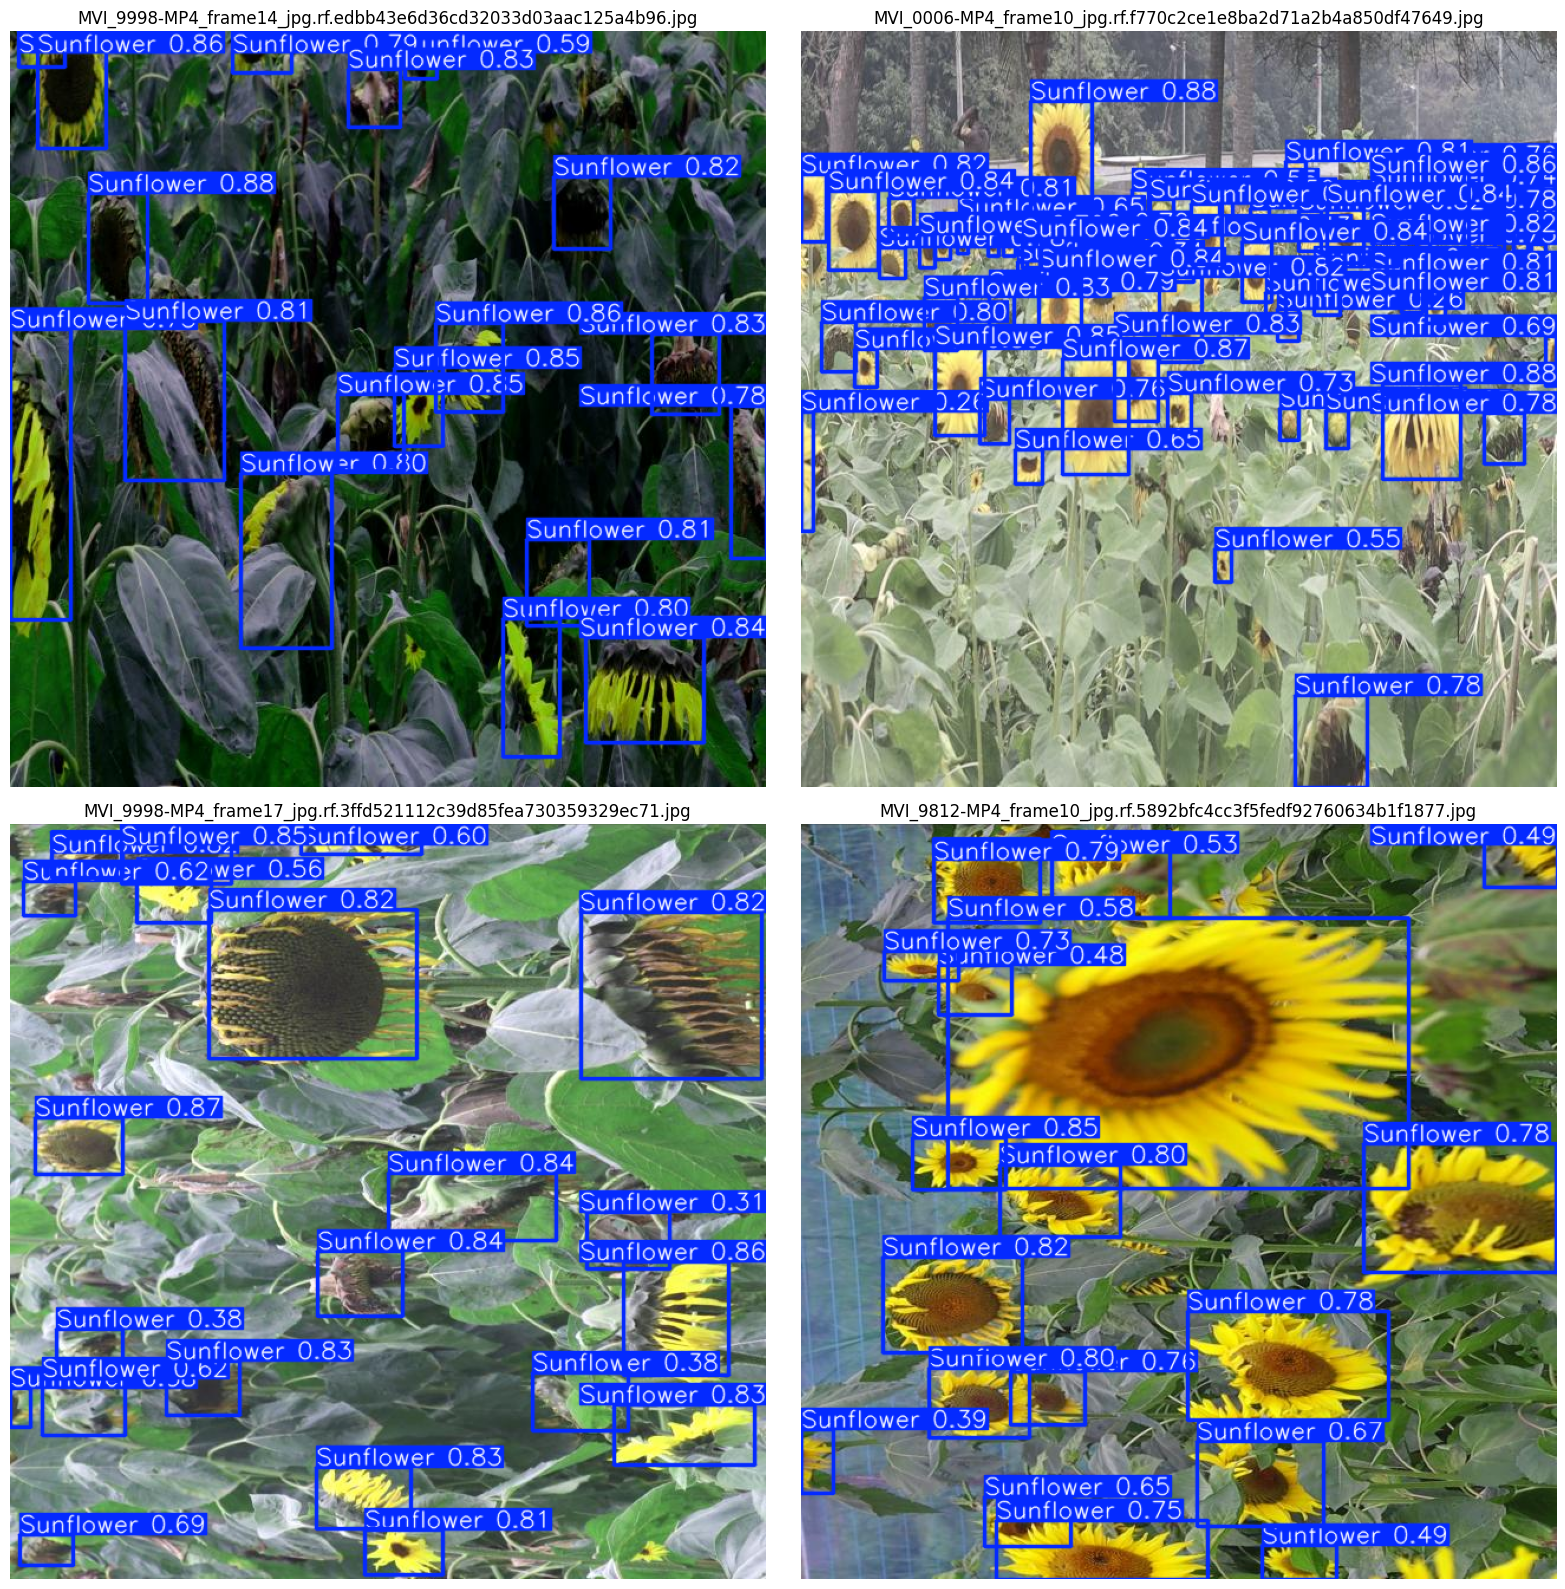

In [6]:
import random
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure inline plotting for Jupyter
%matplotlib inline  

best_pt = Path("D:/EWU/10th Semester/CSE475/LABS/Project/DINO/SSL-DINO/ssl_yolov11s_dinov2/weights/best.pt")
 
model_det = YOLO(str(best_pt))

# Get all test images
test_imgs = list((WORK / "test/images").glob("*.*"))

if len(test_imgs) >= 4:
    # Pick 4 random images
    selected_imgs = random.sample(test_imgs, 4)

    plt.figure(figsize=(16, 16))
    for i, img_path in enumerate(selected_imgs, start=1):
        print(f"[{i}] Predicting: {img_path.name}")
        pred = model_det.predict(
            source=str(img_path),
            imgsz=640,
            conf=0.25,
            device=0 if device == "cuda" else "cpu",
            verbose=False
        )[0]

        plotted_img = pred.plot()[:, :, ::-1] if pred else plt.imread(img_path)

        plt.subplot(2, 2, i)
        plt.imshow(plotted_img)
        plt.axis("off")
        plt.title(img_path.name)

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough test images found (found {len(test_imgs)}, need at least 4).")
